# Lego World Map

Code inspired from Milan Janosov to create a stylized elevation map of the world.

You can read about his work creating a Lego elevation map of Budapest [here](https://open.substack.com/pub/milanjanosov/p/lego-elevation-map?r=3mp6w8&utm_medium=ios) on his Substack.

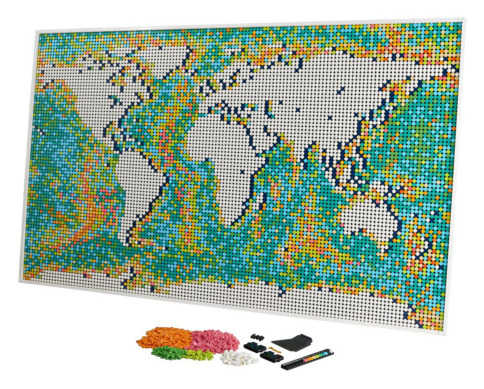

In [188]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# https://jaysbrickblog.com/wp-content/uploads/2021/05/\
# LEGO-31203-World-Map-Product-Photo-1024x815.jpg
img = mpimg.imread('figures/LEGO-31203-World-Map-Product-Photo-1024x815.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Lego has previously made a world map, but I think I could do a little better!

## Imports

In [189]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.features import rasterize, geometry_mask
from rasterio.transform import from_bounds
from rasterio import transform
from affine import Affine
import rasterio as rio
from rasterio.io import MemoryFile
from rasterio.enums import Resampling
import sys
import subprocess
import glob
import string
from osgeo import gdal
from pathlib import Path
import os
from shapely.geometry import box, LineString
from shapely.affinity import scale
from PIL import Image, ImageEnhance
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from skimage.color import rgb2lab, lab2rgb
from sklearn.cluster import KMeans
from rasterstats import zonal_stats
import math
from scipy import ndimage

DEM Raster data sourced from here:

https://earthexplorer.usgs.gov

## Helper Functions

In [190]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [191]:
seed=rand_gen()
seed

1755

In [192]:
# save random seed for project
with open('seed.txt', 'w') as file:
    file.write(str(seed))

In [193]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x3436B6420

## Merge DEMs

In [194]:
# adapted from https://gis.stackexchange.com/questions/449569/\
# merging-a-large-number-of-geotiff-files-via-gdal-merge-py

# paths
input_folder=Path('../_data/world_data/dem_tile_world_gtopo30')
output_folder=Path('../_data/world_data')
output_file=output_folder / "dem_world_gtopo30.tiff"
vrt_file=output_folder / "merged.vrt"

# create output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# find and list all .tif files
input_files = [Path(file) for file in glob.glob(str(input_folder / '*.tif'))]
print(f"Found {len(input_files)} files to merge.")

# dictionary for temporary short names
# to manage potentially long filenames
original_names = {}
characters = string.digits + string.ascii_letters

# temporarily rename files to short names
print("Renaming files temporarily...")
for i, file in enumerate(input_files):
    new_name = f"{characters[i % len(characters)]}{characters[i // len(characters)]}.t"
    new_path = file.parent / new_name
    file.rename(new_path)
    original_names[new_path] = file

# build VRT from renamed files
print("Building VRT file...")
gdal.BuildVRT(str(vrt_file), [str(file) for file in original_names.keys()])

# translate VRT to TIFF
print("Translating VRT to TIFF...")
gdal.Translate(str(output_file), str(vrt_file))

# restore original file names
print("Restoring original file names...")
for new_path, original_path in original_names.items():
    new_path.rename(original_path)

# clean up VRT file
print("Cleaning up temporary files...")
vrt_file.unlink()

print(f"Merging completed. Final output located at: {output_file}")

Found 33 files to merge.
Renaming files temporarily...
Building VRT file...
Translating VRT to TIFF...
Restoring original file names...
Cleaning up temporary files...
Merging completed. Final output located at: ../_data/world_data/dem_world_gtopo30.tiff


Saved image to ../_figs/dem_world.jpg


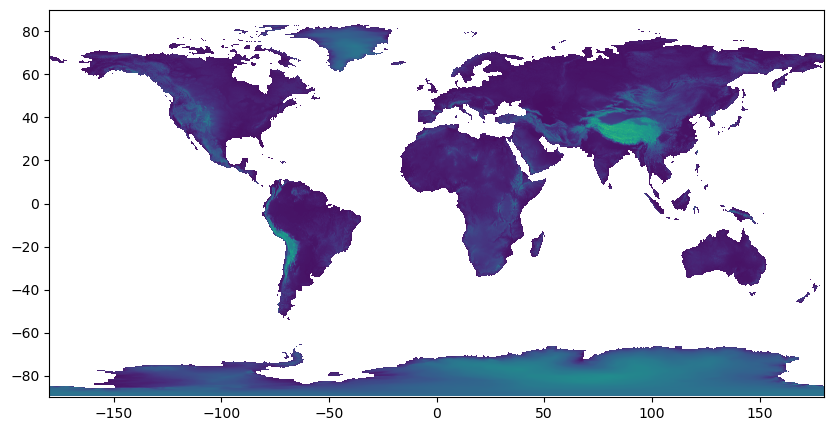

In [195]:
# save as jpg for posterity

# define paths
tiff_file=Path('../_data/world_data/dem_world_gtopo30.tiff')
output_image=Path('../_figs/dem_world.jpg')
output_image.parent.mkdir(parents=True,exist_ok=True)

# open and save as jpg
with rio.open(tiff_file) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src,ax=ax)
    plt.savefig(output_image,format="jpg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    
print(f'Saved image to {output_image}')

In [196]:
# confirm cell size and dimensions of raster
# Path to the GeoTIFF file
file_path = '../_data/world_data/dem_world_gtopo30.tiff'

# Open the GeoTIFF file
with rio.open(file_path) as src:
    # Get pixel size (resolution)
    transform = src.transform
    pixel_width = abs(transform.a)  # Pixel width (x-direction)
    pixel_height = abs(transform.e)  # Pixel height (y-direction)
    
    # Get raster dimensions
    width = src.width  # Number of pixels in x-direction
    height = src.height  # Number of pixels in y-direction
    
    # Calculate aspect ratio
    aspect_ratio = width / height

# Print the results
print(f"Pixel size: {pixel_width} x {pixel_height}")
print(f"Raster dimensions: {width} x {height}")
print(f"Aspect ratio: {aspect_ratio:.2f} ({'landscape' if aspect_ratio > 1 else 'portrait' if aspect_ratio < 1 else 'square'})")

Pixel size: 0.00833333333333 x 0.00833333333333
Raster dimensions: 43200 x 21600
Aspect ratio: 2.00 (landscape)


## "Lego-fy" or downsample polygon of earth

Now we have to rasterize the elevation map. This is crucial as we'll be eventually making this map in Lego, which are bricks (duh).

We need to have a look at the boundaries of the world. I have a file downloaded already:

In [197]:
import geopandas as gpd
import shapely
print(f'GeoPandas version: {gpd.__version__}')
print(f'Shapely version: {shapely.__version__}')

GeoPandas version: 0.14.2
Shapely version: 2.0.6


<Axes: >

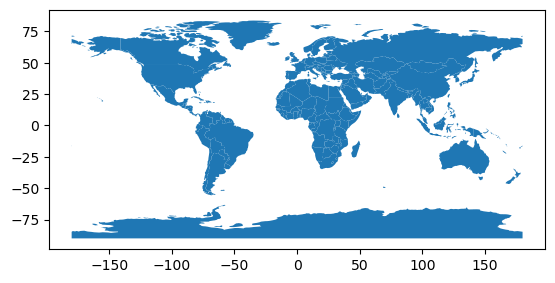

In [198]:
borders = gpd.read_file('../_data/world_data/world_borders.geojson')
borders.plot()

In [199]:
# merge into one mega-world-spanning polygon
world_polygon = borders.geometry.unary_union
world = gpd.GeoDataFrame(geometry=[world_polygon], crs=borders.crs)
world.to_parquet('../_data/world_data/world_polygon.parquet', engine='pyarrow')

/Applications/Anaconda/anaconda3/envs/lego/lib/python3.10/site-packages/shapely/set_operations.py:421: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


<Figure size 640x480 with 0 Axes>

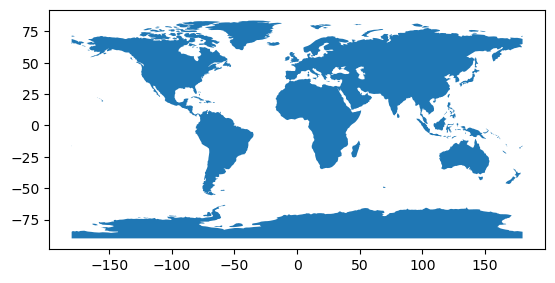

In [200]:
world = gpd.read_parquet('../_data/world_data/world_polygon.parquet')
plt.figure()
world.plot()

plt.savefig('figures/world_polygon.jpg',bbox_inches='tight')

In [201]:
# confirm cell size and dimensions of shape
# Path to the GeoParquet file
file_path = '../_data/world_data/world_polygon.parquet'

# Load the GeoParquet file into a GeoDataFrame
gdf = gpd.read_parquet(file_path)

# Calculate the bounding box of the polygon
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds

# Calculate dimensions of the bounding box
width = maxx - minx
height = maxy - miny

# Calculate aspect ratio
aspect_ratio = width / height

# Print the results
print(f"Bounding box: minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")
print(f"Width: {width}")
print(f"Height: {height}")
print(f"Aspect ratio: {aspect_ratio:.2f} ({'landscape' if aspect_ratio > 1 else 'portrait' if aspect_ratio < 1 else 'square'})")

Bounding box: minx=-180.0, miny=-90.0, maxx=180.0, maxy=83.64513
Width: 360.0
Height: 173.64513
Aspect ratio: 2.07 (landscape)


### Transform polygon of world shorelines to be in 2:1 aspect ratio

Since the polygon is not an exact 2:1 ratio, I will transform it using shapely.

In [202]:
# Path to the GeoParquet file
file_path = '../_data/world_data/world_polygon.parquet'

# Load the GeoParquet file
gdf = gpd.read_parquet(file_path)

# Calculate the current bounding box and aspect ratio
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds
current_width = maxx - minx
current_height = maxy - miny
current_aspect_ratio = current_width / current_height

# Desired aspect ratio
desired_aspect_ratio = 2.00

# Calculate scaling factors
if current_aspect_ratio > desired_aspect_ratio:
    # Landscape: Compress width
    scale_x = desired_aspect_ratio / current_aspect_ratio
    scale_y = 1  # No change in height
else:
    # Portrait: Stretch height
    scale_x = 1  # No change in width
    scale_y = current_aspect_ratio / desired_aspect_ratio

# Apply the scaling transformation
gdf['geometry'] = gdf['geometry'].apply(lambda geom: scale(geom, xfact=scale_x, yfact=scale_y, origin='center'))

# Save the transformed GeoDataFrame (optional)
output_path = '../_data/world_data/world_polygon_transformed.parquet'
gdf.to_parquet(output_path)

# Recalculate the bounding box and aspect ratio for verification
new_bounds = gdf.total_bounds
new_minx, new_miny, new_maxx, new_maxy = new_bounds
new_width = new_maxx - new_minx
new_height = new_maxy - new_miny
new_aspect_ratio = new_width / new_height

# Print results
print(f"Original aspect ratio: {current_aspect_ratio:.2f}")
print(f"Transformed aspect ratio: {new_aspect_ratio:.2f}")
print(f"Saved transformed GeoParquet to: {output_path}")

Original aspect ratio: 2.07
Transformed aspect ratio: 2.00
Saved transformed GeoParquet to: ../_data/world_data/world_polygon_transformed.parquet


<Figure size 640x480 with 0 Axes>

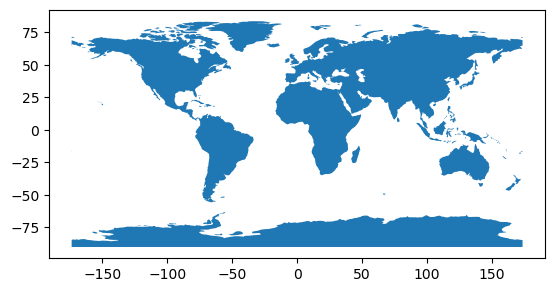

In [203]:
world_t = gpd.read_parquet('../_data/world_data/world_polygon_transformed.parquet')
plt.figure()
world_t.plot()

plt.savefig('figures/world_polygon_transformed.jpg',bbox_inches='tight')

## Create grid, extract to mask, compute zonal statistics

Milan made a function that split the polygon into a grid with a user-specified number of cells. We may have to adapt it as our world map is not a square.

In [204]:
world_t.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We'll have to figure out what the dimensions of the Lego set are (in Lego studs), as that is a good size for our eventual Lego map.
* The map is 5 x 16 or 80 studs in height
* The map is 8 x 16 or 128 studs in width

That being said, the resulting map will be stretched; for example, Africa in the above dimensions will appear long. I prefer 80 x 160 as the aspect ratio (2:1) is what we expect from typical world maps.

The earth has 360 degrees in total width and 180 degrees in total height. The grid cellsize will be the following, with a figure that has 160 x 80 grid cells:  
* 360/160 = 2.25
* 180/80 = 2.25

Therefore, each grid cell will be 2.25 degrees square.

Grid saved to: ../_data/world_data/world_grid.geojson
Zonal statistics saved to: ../_data/world_data/world_zonal_stats.geojson


<Axes: >

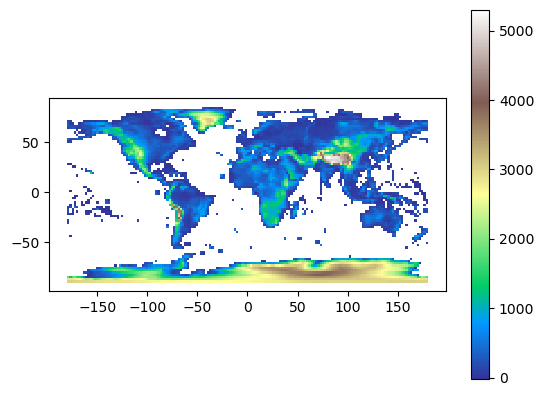

In [205]:
# File paths
input_dem = '../_data/world_data/dem_world_gtopo30.tiff'
output_grid = '../_data/world_data/world_grid.geojson'
output_stats = '../_data/world_data/world_zonal_stats.geojson'

# Define the grid resolution (degrees per cell)
grid_size = 2.25  # Adjust as needed (2° x 2° cells)

# Step 1: Create a uniform grid
def create_grid(extent, grid_size):
    minx, miny, maxx, maxy = extent
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    polygons = [
        box(x, y, x + grid_size, y + grid_size)
        for x in x_coords for y in y_coords
    ]
    grid = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:4326')
    return grid

# Read DEM to get its bounds
with rio.open(input_dem) as src:
    dem_bounds = src.bounds  # (minx, miny, maxx, maxy)

# Create the grid
grid = create_grid(dem_bounds, grid_size)
grid.to_file(output_grid, driver='GeoJSON')
print(f"Grid saved to: {output_grid}")

# Step 2: Calculate zonal statistics (mean elevation per grid cell)
zonal_stats_result = zonal_stats(
    grid, input_dem, stats=['mean'], geojson_out=True
)

# Convert results to GeoDataFrame
zonal_stats_gdf = gpd.GeoDataFrame.from_features(zonal_stats_result, crs='EPSG:4326')

# Save results
zonal_stats_gdf.to_file(output_stats, driver='GeoJSON')
print(f"Zonal statistics saved to: {output_stats}")

# Step 3: Visualize (Optional)
zonal_stats_gdf.plot(column='mean', cmap='terrain', legend=True)


### Discretize elevation

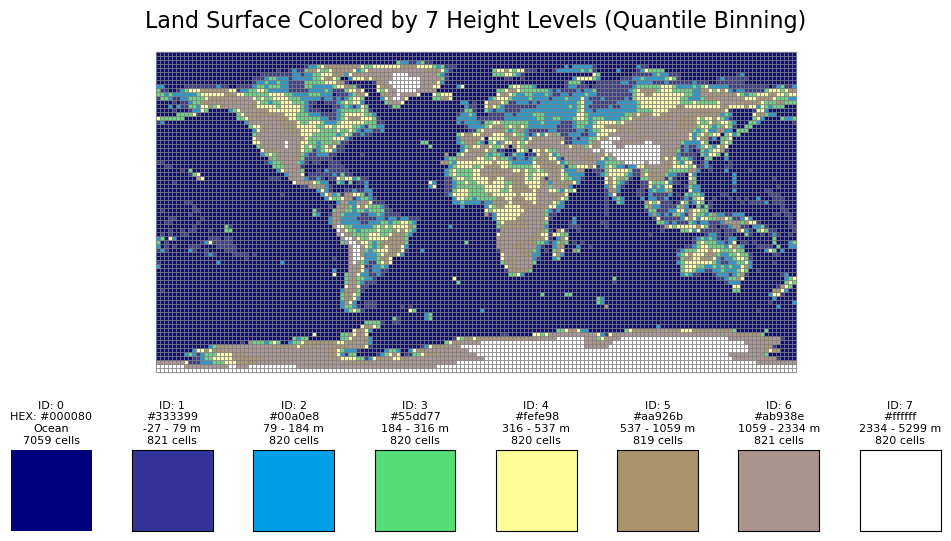

In [206]:
# --- Load the data ---
input_stats = '../_data/world_data/world_zonal_stats.geojson'
gdf_grid = gpd.read_file(input_stats)

# Number of levels (user-defined)
n_levels = 7

# Custom RGBA color for areas with no data
no_data_color = [0, 0, 0.5, 1]  # Dark blue (RGBA)

# Step 1: Add a no-data mask
gdf_grid['height_level'] = -1  # Initialize all values as "-1" for no data
gdf_grid.loc[gdf_grid['mean'].notna(), 'height_level'] = 0  # Temporary placeholder

# Step 2: Filter for valid elevation data
valid_data = gdf_grid['mean'].notna()
gdf_valid = gdf_grid[valid_data].copy()

# Step 3: Apply quantile binning to redistribute valid data into levels
gdf_valid['height_level'] = pd.qcut(
    gdf_valid['mean'], 
    q=n_levels, 
    labels=range(n_levels)
).astype(int)

# Update the original GeoDataFrame with binned values
gdf_grid.loc[valid_data, 'height_level'] = gdf_valid['height_level']

# Step 4: Define the colormap
terrain_colors = cm.terrain(np.linspace(0, 1, n_levels))  # Colormap for valid data
cmap = mcolors.ListedColormap([no_data_color] + list(terrain_colors))  # Include no-data color

# Step 5: Visualization
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 0.5], hspace=0.25)  # Adjusted for better layout

# --- Main Plot ---
ax_main = fig.add_subplot(gs[0])

# Plot base grid with grey edges
gdf_grid.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# Plot grid colored by height levels
gdf_grid.plot(
    ax=ax_main,
    column='height_level',
    edgecolor='grey',
    linewidth=0.5,
    cmap=cmap,
    alpha=0.95,
    categorical=True
)

ax_main.axis('off')
ax_main.set_title(f"Land Surface Colored by {n_levels} Height Levels (Quantile Binning)", fontsize=16)

# --- Subplots: Color Swatches with Pixel Information ---
total_levels = n_levels + 1  # Include "No Data" as an additional level
gs_swatch = GridSpecFromSubplotSpec(1, total_levels, subplot_spec=gs[1, 0], wspace=0.5)

# Compute elevation intervals
quantiles = [gdf_valid['mean'].quantile(q / n_levels) for q in range(n_levels + 1)]
level_counts = gdf_grid['height_level'].value_counts().to_dict()

# Add the swatch for "No Data" first
ocean_count = level_counts.get(-1, 0)
ax_ocean = fig.add_subplot(gs_swatch[0, 0])
ax_ocean.imshow([[no_data_color]])  # Swatch for "No Data"
ax_ocean.axis('off')  # No borders
ax_ocean.set_title(
    f"ID: 0\nHEX: {mcolors.to_hex(no_data_color)}\nOcean\n{ocean_count} cells",
    fontsize=8,
    pad=5
)

# Loop to add swatches for each elevation level (IDs start from 1)
for i in range(n_levels):
    color = terrain_colors[i]
    hex_color = mcolors.to_hex(color)
    count = level_counts.get(i, 0)
    elevation_interval = f"{quantiles[i]:.0f} - {quantiles[i + 1]:.0f} m"
    
    ax_swatch = fig.add_subplot(gs_swatch[0, i + 1])  # Offset by 1 to accommodate "No Data"
    ax_swatch.imshow([[color]])  # Swatch
    # ax_swatch.axis('off')  # No borders
    ax_swatch.get_xaxis().set_ticks([])
    ax_swatch.get_yaxis().set_ticks([])
    ax_swatch.set_title(
        f"ID: {i + 1}\n{hex_color}\n{elevation_interval}\n{count} cells",
        fontsize=8,
        pad=5
    )

# Save the updated visualization
plt.savefig(f'{output_folder}/elevation_overview_{n_levels}_with_info.png', bbox_inches='tight')
plt.savefig(f'{output_folder}/elevation_overview_{n_levels}_with_info.pdf', bbox_inches='tight')
plt.savefig(f'{output_folder}/elevation_overview_{n_levels}_with_info.jpg', bbox_inches='tight')

plt.show()

### Overview of Patches

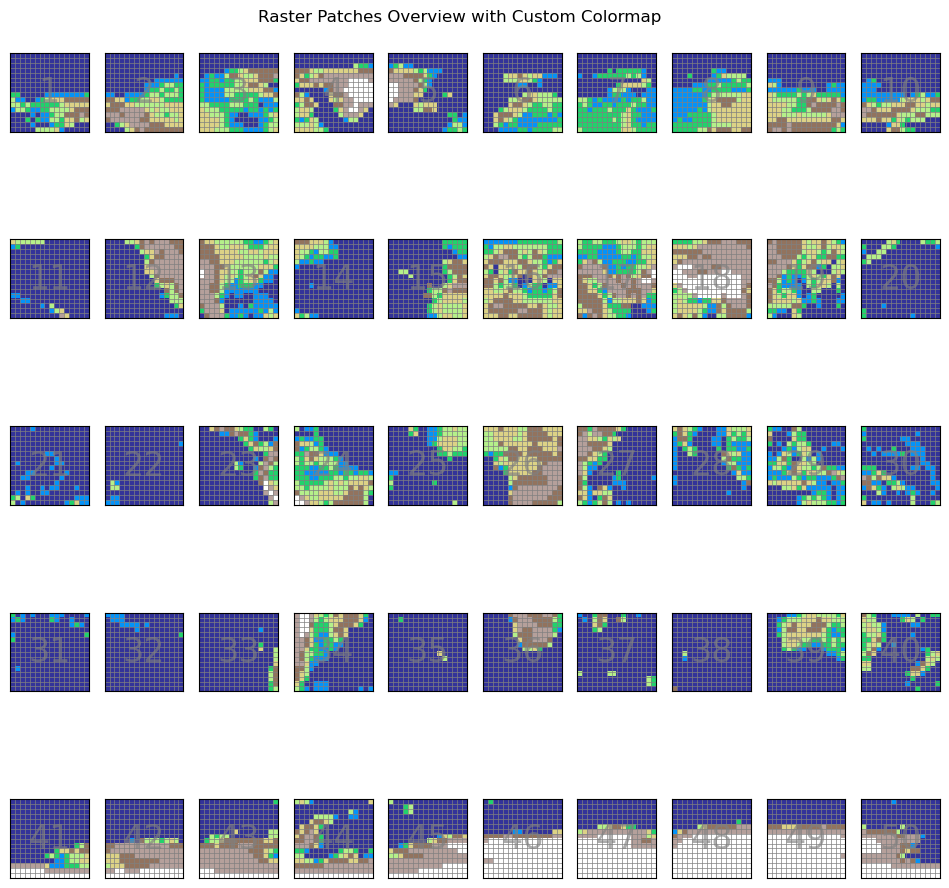

In [207]:
# Assuming `gdf_grid` is already loaded
# gdf_grid has 12,800 rows
num_rows = gdf_grid.shape[0]

# Define bounds and calculate pixel dimensions for 2:1 aspect ratio
bounds = gdf_grid.total_bounds  # xmin, ymin, xmax, ymax
height = int(np.sqrt(num_rows / 2))  # Height is sqrt(num_rows / 2) for 2:1 aspect ratio
width = 2 * height  # Width is twice the height
resolution_x = (bounds[2] - bounds[0]) / width
resolution_y = (bounds[3] - bounds[1]) / height

# Ensure transform aligns exactly with the GeoDataFrame
transform = rio.transform.from_origin(bounds[0], bounds[3], resolution_x, resolution_y)

# Rasterize the GeoDataFrame: map geometry to the 'height_level' column
shapes = ((geom, value) for geom, value in zip(gdf_grid.geometry, gdf_grid['height_level']))
raster = rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Default value for pixels with no data
    dtype=np.float32,
)

# Normalize the raster for image visualization (optional)
raster_min = raster.min()
raster_max = raster.max()
raster_norm = ((raster - raster_min) / (raster_max - raster_min) * 255).astype(np.uint8)

# Extract unique values and normalize them for the custom colormap
unique_values = np.unique(raster_norm)
norm = mcolors.Normalize(vmin=raster_norm.min(), vmax=raster_norm.max())
colors = plt.cm.terrain(unique_values / 255.)  # Normalized to [0, 1] for color mapping
custom_cmap = mcolors.ListedColormap(colors)

# Parameters for patches
patch_height = 16
patch_width = 16

# Calculate the number of patches along each dimension
n_patches_y = raster_norm.shape[0] // patch_height
n_patches_x = raster_norm.shape[1] // patch_width
total_patches = n_patches_x * n_patches_y

# Create the figure for visualization
fig, axs = plt.subplots(n_patches_y, n_patches_x, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.05)

# Extract and plot each patch
patch_number = 1
for i in range(n_patches_y):
    for j in range(n_patches_x):
        # Slice the patch
        patch = raster_norm[
            i * patch_height: (i + 1) * patch_height,
            j * patch_width: (j + 1) * patch_width,
        ]
        # Plot the patch with custom colormap
        ax = axs[i, j]
        img = ax.imshow(patch, cmap=custom_cmap, norm=norm)

        # Add vertical and horizontal lines to act as grid lines
        ax.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)
        ax.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)
        ax.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)
        ax.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)

        # Optional: Add lines between pixels
        for y in range(1, patch_height):
            ax.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)
        for x in range(1, patch_width):
            ax.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)

        # Add tick labels
        ax.set_xticks(np.arange(0, patch_width, 1))
        ax.set_yticks(np.arange(0, patch_height, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        # Adjust tick label spacing
        ax.tick_params(axis='x', labelsize=2.5, pad=0.5)
        ax.tick_params(axis='y', labelsize=2.5, pad=0.5)

        # Add a large number denoting patch position
        ax.text(
            x=0.5, y=0.5, 
            s=str(patch_number), c='grey', alpha=0.65, 
            transform=ax.transAxes, fontsize=24, 
            ha='center', va='center'
        )

        patch_number += 1

# Add a title
plt.suptitle(t=f'Raster Patches Overview with Custom Colormap', y=0.875)

# Save the figure
plt.savefig('figures/elevation_raster_patches_custom_colormap_fixed.pdf', bbox_inches='tight')
plt.savefig('figures/elevation_raster_patches_custom_colormap_fixed.png', bbox_inches='tight')
plt.savefig('figures/elevation_raster_patches_custom_colormap_fixed.jpg', bbox_inches='tight')

# Show the figure
plt.show()

Perfect. Now I will save each individual patch as its own file for ease of use in buliding the map.

In [208]:
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
# import matplotlib.image as mpimg

# # Access unique color list object
# color_to_id = {tuple(color): idx for idx, color in enumerate(custom_cmap.colors)}

# # Create a directory to save individual patches
# output_dir = 'figures/elevation_patches'
# os.makedirs(output_dir, exist_ok=True)

# patch_number = 1
# for i in range(n_patches_y):
#     for j in range(n_patches_x):
#         # Slice the patch
#         patch = raster_norm[i * patch_height: (i + 1) * patch_height, j * patch_width: (j + 1) * patch_width]

#         # Count unique colors in the patch (adjust for grayscale)
#         if patch.ndim == 3 and patch.shape[2] == 3:  # RGB
#             unique_colors, counts = np.unique(patch.reshape(-1, 3), axis=0, return_counts=True)
#             hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]
#         else:  # Grayscale
#             unique_colors = np.unique(patch)  # For grayscale, use 1D array
#             counts = [np.sum(patch == color) for color in unique_colors]
#             hex_colors = [f'#{color:02x}{color:02x}{color:02x}' for color in unique_colors]

#         # Create a figure with gridspec for patch display
#         fig = plt.figure(figsize=(6, 8))
#         gs = GridSpec(2, 1, height_ratios=[1, 0.1], hspace=0.4)  # 2-row grid, second row for swatches

#         # Plot the patch using the custom colormap
#         ax_patch = fig.add_subplot(gs[0, 0])
#         img = ax_patch.imshow(patch, cmap=custom_cmap, norm=norm)  # Apply custom colormap
#         ax_patch.set_title(f'Patch {patch_number}', fontsize=16)

#         # Add tick labels
#         ax_patch.set_xticks(np.arange(0, patch_width, 1))
#         ax_patch.set_yticks(np.arange(0, patch_height, 1))
#         ax_patch.set_xticklabels(range(patch_width))
#         ax_patch.set_yticklabels(range(patch_height))

#         # Adjust tick label spacing
#         ax_patch.tick_params(axis='x', labelsize=5, pad=2)  # Adjust for visibility
#         ax_patch.tick_params(axis='y', labelsize=5, pad=2)

#         # Add gridlines
#         ax_patch.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
#         ax_patch.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
#         ax_patch.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
#         ax_patch.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
#         for y in range(1, patch_height):
#             ax_patch.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)
#         for x in range(1, patch_width):
#             ax_patch.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)

#         # Overlay the unique color labels on each cell
#         for idx, (color, count) in enumerate(zip(unique_colors, counts)):
#             # Convert color to RGBA format if it's RGB or grayscale
#             if patch.ndim == 3 and patch.shape[2] == 3:  # RGB
#                 rgba_color = tuple(np.append(color, 1.0))  # Add alpha channel
#             else:  # Grayscale
#                 rgba_color = (color / 255.0, color / 255.0, color / 255.0, 1.0)  # Convert grayscale to RGBA

#             # Map the RGBA color to the color_to_id dictionary
#             color_id = color_to_id.get(rgba_color, None)  # Use .get() to avoid KeyError if color is not found
#             if color_id is not None:
#                 color_str = str(color_id)
#             else:
#                 color_str = "Unknown"

#             # Find the pixel locations for this color in the patch
#             if patch.ndim == 3 and patch.shape[2] == 3:  # RGB
#                 y, x = np.where(np.all(patch == color, axis=-1))
#             else:  # Grayscale
#                 y, x = np.where(patch == color)

#             # Annotate the patch with the color label
#             for xi, yi in zip(x, y):
#                 ax_patch.text(xi, yi, color_str, color='white', ha='center', va='center', fontsize=8)

#         # Create a color swatch row below the patch
#         ax_swatches = fig.add_subplot(gs[1, 0])
#         for idx, color in enumerate(unique_colors):
#             # Handle grayscale or RGB color
#             if patch.ndim == 3 and patch.shape[2] == 3:  # RGB
#                 rgba_color = tuple(np.append(color, 1.0))  # Add alpha channel
#             else:  # Grayscale
#                 rgba_color = (color / 255.0, color / 255.0, color / 255.0, 1.0)  # Convert grayscale to RGBA

#             # Plot the swatch with correct color
#             ax_swatches.add_patch(plt.Rectangle((idx * 0.1, 0), 0.1, 1, color=rgba_color))
#             ax_swatches.text(idx * 0.1 + 0.05, 1.02, str(unique_colors[idx]), ha='center', fontsize=8)

#         # Remove axes for swatches
#         ax_swatches.axis('off')

#         # Save the figure in multiple formats
#         patch_file_base = f'{output_dir}/test/patch_{patch_number:03d}'
#         plt.savefig(f'{patch_file_base}.pdf', bbox_inches='tight')
#         plt.savefig(f'{patch_file_base}.png', bbox_inches='tight')
#         plt.savefig(f'{patch_file_base}.jpg', bbox_inches='tight')

#         # Close the figure to save memory
#         plt.close(fig)

#         patch_number += 1

# print(f"All patches saved to {output_dir}")

# # Display an example patch
# img = mpimg.imread('figures/elevation_patches/test/patch_013.jpg')
# imgplot = plt.imshow(img)
# plt.axis('off')
# plt.show()

All patches saved to figures/elevation_patches


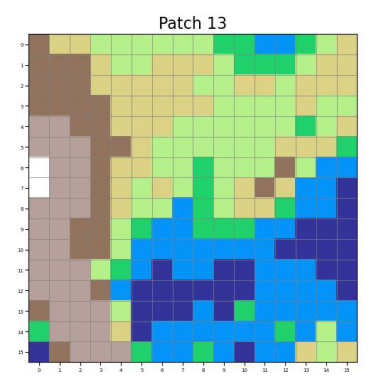

In [209]:
# Access unique color list object
color_to_id = {tuple(color): idx for idx, color in enumerate(custom_cmap.colors)}

# Create a directory to save individual patches
output_dir = 'figures/elevation_patches'
os.makedirs(output_dir, exist_ok=True)

patch_number = 1
for i in range(n_patches_y):
    for j in range(n_patches_x):
        # Slice the patch
        patch = raster_norm[i * patch_height: (i + 1) * patch_height, j * patch_width: (j + 1) * patch_width]

        # Count unique colors in the patch (adjust for grayscale)
        if patch.ndim == 3 and patch.shape[2] == 3:  # RGB
            unique_colors, counts = np.unique(patch.reshape(-1, 3), axis=0, return_counts=True)
            hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]
        else:  # Grayscale
            unique_colors = np.unique(patch)  # For grayscale, use 1D array
            counts = [np.sum(patch == color) for color in unique_colors]
            hex_colors = [f'#{color:02x}{color:02x}{color:02x}' for color in unique_colors]

        # Create a figure with gridspec for patch display
        fig = plt.figure(figsize=(6, 6))
        gs = GridSpec(1, 1, height_ratios=[1], hspace=0.4)

        # Plot the patch using the custom colormap
        ax_patch = fig.add_subplot(gs[0, 0])
        img = ax_patch.imshow(patch, cmap=custom_cmap, norm=norm)  # Apply custom colormap
        ax_patch.set_title(f'Patch {patch_number}', fontsize=16)

        # Add tick labels
        ax_patch.set_xticks(np.arange(0, patch_width, 1))
        ax_patch.set_yticks(np.arange(0, patch_height, 1))
        ax_patch.set_xticklabels(range(patch_width))
        ax_patch.set_yticklabels(range(patch_height))

        # Adjust tick label spacing
        ax_patch.tick_params(axis='x', labelsize=5, pad=2)  # Adjust for visibility
        ax_patch.tick_params(axis='y', labelsize=5, pad=2)

        # Add gridlines
        ax_patch.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
        ax_patch.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
        ax_patch.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
        ax_patch.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
        for y in range(1, patch_height):
            ax_patch.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)
        for x in range(1, patch_width):
            ax_patch.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)

        # Remove any numbers or labels from the cells
        # No need to overlay IDs or count numbers, so we omit that section

        # Save the figure in multiple formats
        patch_file_base = f'{output_dir}/patch_{patch_number:03d}'
        plt.savefig(f'{patch_file_base}.pdf', bbox_inches='tight')
        plt.savefig(f'{patch_file_base}.png', bbox_inches='tight')
        plt.savefig(f'{patch_file_base}.jpg', bbox_inches='tight')

        # Close the figure to save memory
        plt.close(fig)

        patch_number += 1

print(f"All patches saved to {output_dir}")

# Display an example patch
img = mpimg.imread('figures/elevation_patches/patch_013.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Add surface color

We will downsample the colors of the bare earth surface to add to our lego map.

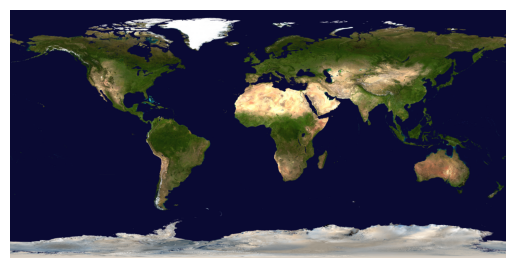

In [210]:
# https://svs.gsfc.nasa.gov/vis/a000000/a002900/a002915/bluemarble-2048.png
# thankfully this is in the same projection as our other assets
img = mpimg.imread('figures/bluemarble-2048.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

First, let's count the number of colors that the above image has.

In [211]:
# load the image and convert to RGB mode
image = Image.open('figures/bluemarble-2048.png').convert("RGB")

# convert image to a numpy array
image_array = np.array(image)

# reshape the array into a list of RGB values
pixels = image_array.reshape(-1, 3)

# count unique colors
unique_colors = np.unique(pixels, axis=0)
print(f"Number of unique colors: {len(unique_colors)}")

Number of unique colors: 220909


That's quite a large number of colors. We'll use the Median Cut algorithm to cluster the colors into a much smaller number. Let's see what a much reduced amount (≤15) gives us.

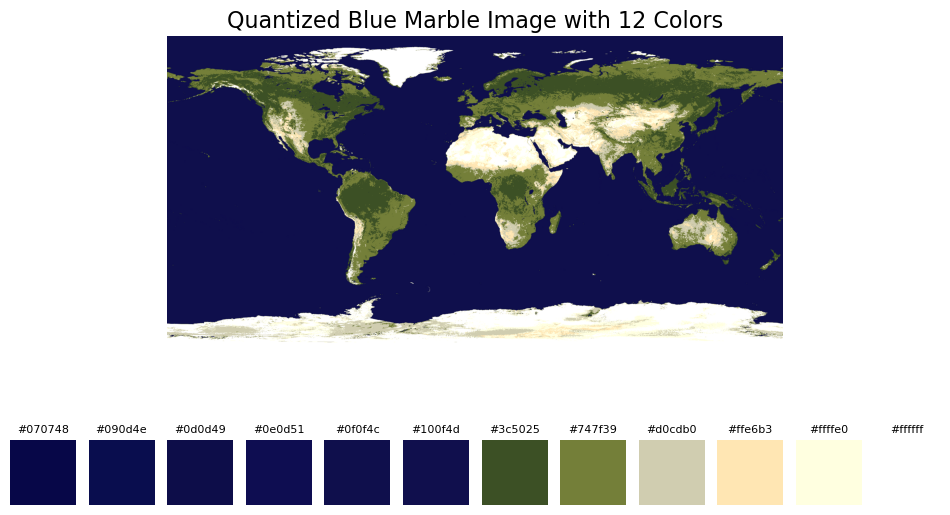

In [212]:
n_colors = 12
brightness_factor = 1.5  # factor to increase brightness

# load the image and convert to RGB
image = Image.open('figures/bluemarble-2048.png').convert("RGB")

# enhance the brightness
enhancer = ImageEnhance.Brightness(image)
brightened_image = enhancer.enhance(brightness_factor)

# apply quantization with Median Cut
quantized_image = brightened_image.quantize(method=Image.MEDIANCUT, colors=n_colors).convert('RGB')

# save the quantized image
saved_img_path = f'figures/bluemarble-2048_downsampled_with_{n_colors}_colors.png'
quantized_image.save(saved_img_path)

# get the unique colors from the quantized image
unique_colors = np.unique(np.array(quantized_image).reshape(-1, 3), axis=0)

# convert RGB to HEX
hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

# create the figure and grid layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(3, 1, height_ratios=[3, 1, 0.5], hspace=0.5)

# main plot: quantized image
ax_main = fig.add_subplot(gs[0, 0])
ax_main.imshow(quantized_image)
ax_main.axis('off')
ax_main.set_title(f'Quantized Blue Marble Image with {n_colors} Colors', fontsize=16)

# subplots: color swatches
gs_swatch = GridSpecFromSubplotSpec(1, n_colors, subplot_spec=gs[1, 0], wspace=0.2)
for i, (color, hex_color) in enumerate(zip(unique_colors, hex_colors)):
    ax_swatch = fig.add_subplot(gs_swatch[0, i])
    ax_swatch.imshow([[color / 255]])  # Normalize RGB to [0, 1]
    ax_swatch.axis('off')
    ax_swatch.set_xticklabels([])
    ax_swatch.set_yticklabels([])
    ax_swatch.set_xticks([])
    ax_swatch.set_yticks([])
    ax_swatch.set_title(hex_color, fontsize=8, pad=5)

# save the plot
plt.savefig(f'figures/bluemarble-2048_downsampled_{n_colors}_example.png', bbox_inches='tight')

plt.show()

### Discretize surface color

In [213]:
saved_img_path = f'figures/bluemarble-2048_downsampled_with_12_colors.png'

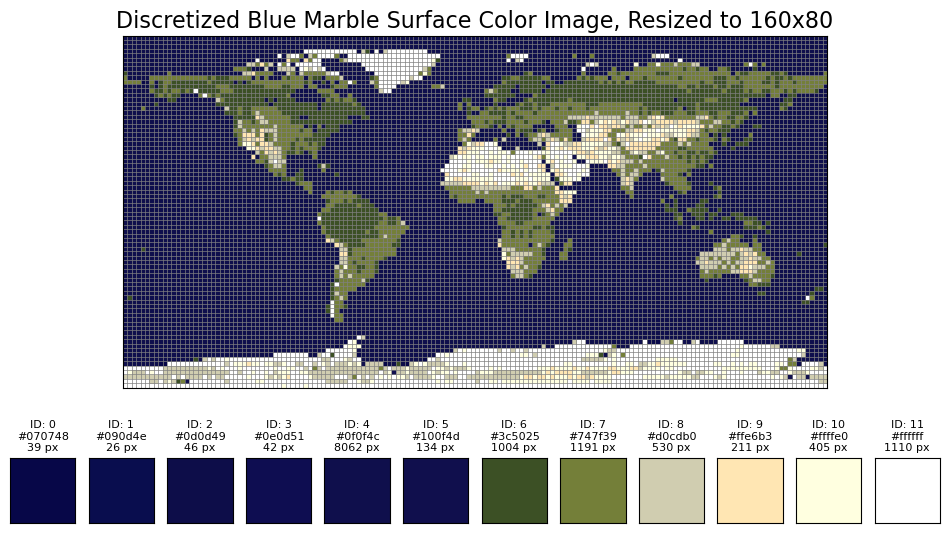

In [214]:
def resize_image_pil(image, target_height, target_width, resample=Image.NEAREST):
    """
    Resize the input image to specified dimensions using PIL.Image.resize.

    Parameters:
    - image (PIL.Image.Image): Input image to be resized.
    - target_height (int): Desired height in pixels.
    - target_width (int): Desired width in pixels.
    - resample: Resampling filter (default: Image.NEAREST for minimal color blending).

    Returns:
    - PIL.Image.Image: Resized image as a PIL Image object.
    """
    # Resize the image
    resized_image = image.resize((target_width, target_height), resample=resample)
    return resized_image

# Parameters
target_height = 80  # height in pixels
target_width = 160   # width in pixels

# Load the quantized image
quantized_image = Image.open('figures/bluemarble-2048_downsampled_with_12_colors.png').convert("RGB")

# Downsample the quantized image using PIL.Image.resize
resized_image = resize_image_pil(quantized_image, target_height, target_width)

# Save the resized image
image_path = f'figures/bluemarble_{target_width}x{target_height}'
image_path_with_ext = image_path + '.png'
resized_image.save(image_path_with_ext)

# Convert the resized image to a NumPy array
resized_array = np.array(resized_image)

# Count the number of pixels for each unique color
unique_colors_surface, counts = np.unique(resized_array.reshape(-1, 3), axis=0, return_counts=True)

# Convert RGB colors to HEX for visualization
hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

# Display results
# for color, count in zip(hex_colors, counts):
    # print(f"Color {color}: {count} pixels")

# Visualization: Resized Image and Color Swatches with Counts
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(3, 1, height_ratios=[3, 1, 0.5], hspace=0.25)

# --- Main Plot: Resized Image ---
ax_main = fig.add_subplot(gs[0, 0])
ax_main.imshow(resized_image)
# ax_main.axis('off')
ax_main.set_title(f'Discretized Blue Marble Surface Color Image, Resized to {target_width}x{target_height}', fontsize=16)

# --- Subplots: Color Swatches with Pixel Counts ---
gs_swatch = GridSpecFromSubplotSpec(1, len(unique_colors), subplot_spec=gs[1, 0], wspace=0.2)
for i, (color, hex_color, count) in enumerate(zip(unique_colors, hex_colors, counts)):
    ax_swatch = fig.add_subplot(gs_swatch[0, i])
    ax_swatch.imshow([[color / 255]])  # Normalize RGB to [0, 1]
    # ax_swatch.axis('off')
    ax_swatch.get_xaxis().set_ticks([])
    ax_swatch.get_yaxis().set_ticks([])
    ax_swatch.set_title(f"ID: {i}\n{hex_color}\n{count} px", fontsize=8, pad=5)

# Add a grid overlay
# for y in range(height):
#     ax_main.axhline(y - 0.5, color='grey', linewidth=0.5)  # Horizontal lines
# for x in range(width):
#     ax_main.axvline(x - 0.5, color='grey', linewidth=0.5)  # Vertical lines

ax_main.set_xticks(np.arange(-0.5, target_width, 1), minor=True)  # Vertical grid lines
ax_main.set_yticks(np.arange(-0.5, target_height, 1), minor=True)  # Horizontal grid lines
ax_main.grid(which="minor", color="grey", linestyle="-", linewidth=0.5)  # Grid styling
ax_main.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)  # Hide minor ticks

plt.savefig('figures/patches/surface_color_overview.png', bbox_inches='tight')
plt.savefig('figures/patches/surface_color_overview.pdf', bbox_inches='tight')
plt.savefig('figures/patches/surface_color_overview.jpg', bbox_inches='tight')

plt.show()

That looks much better! To make a builder-friendly version of the main image above, we'll make patches to make it easier to follow along and build.

### Save patches for building

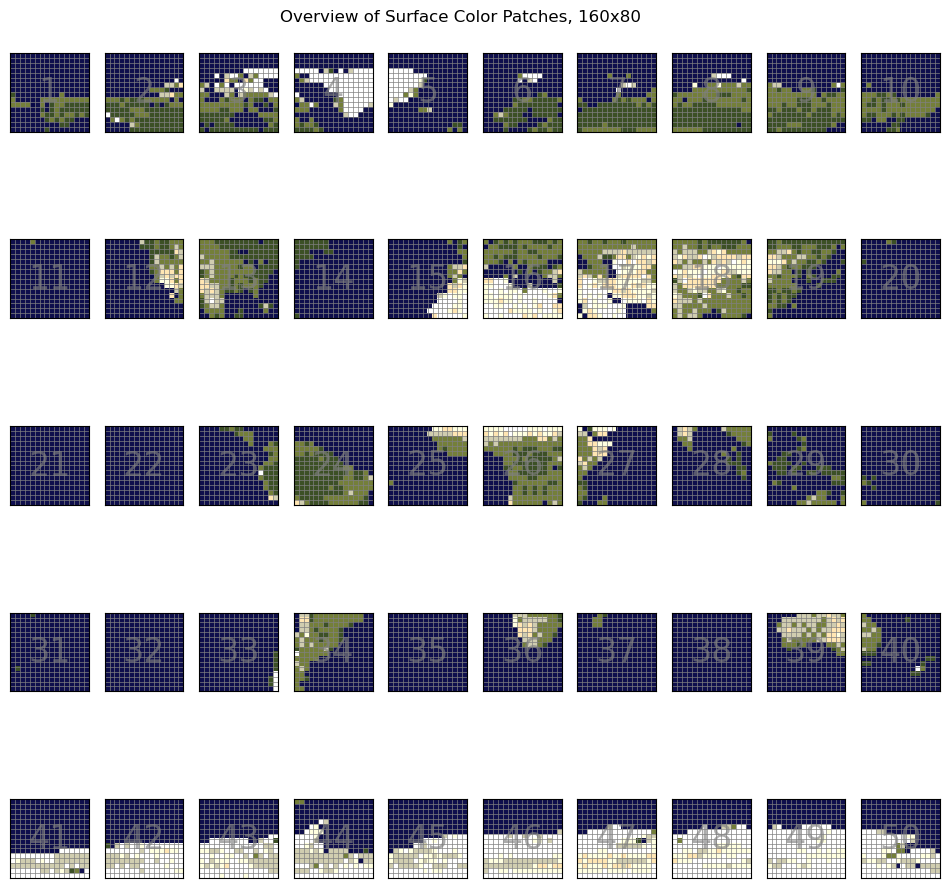

In [215]:
# Parameters for patches
patch_height = 16
patch_width = 16

# Convert the resized image to a NumPy array
image_array = np.array(resized_image)

# Calculate the number of patches along each dimension
n_patches_y = image_array.shape[0] // patch_height
n_patches_x = image_array.shape[1] // patch_width
total_patches = n_patches_x * n_patches_y

# Create the figure for visualization
fig, axs = plt.subplots(n_patches_y, n_patches_x, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.05)  # Adjust space for better visualization

# Extract and plot each patch
patch_number = 1
for i in range(n_patches_y):
    for j in range(n_patches_x):
        # Slice the patch
        patch = image_array[
            i * patch_height: (i + 1) * patch_height,
            j * patch_width: (j + 1) * patch_width,
        ]
        # Plot the patch
        ax = axs[i, j]
        ax.imshow(patch)

        # Add vertical and horizontal lines to act as grid lines
        ax.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
        ax.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
        ax.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
        ax.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
        
        # Optional: Add lines between patches (only if necessary)
        for y in range(1, patch_height):
            ax.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Horizontal lines
        for x in range(1, patch_width):
            ax.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Vertical lines

        # Add local tick labels (0 to 15)
        ax.set_xticks([])
        # ax.set_xticks(np.arange(0, patch_width, 1))
        ax.set_yticks([])
        # ax.set_yticks(np.arange(0, patch_height, 1))
        # ax.set_xticklabels(range(patch_width))
        ax.set_xticklabels([])
        # ax.set_yticklabels(range(patch_height))
        ax.set_yticklabels([])

        # Adjust tick label spacing
        ax.tick_params(axis='x', labelsize=2.5, pad=0.5)  # Reduce horizontal tick label distance
        ax.tick_params(axis='y', labelsize=2.5, pad=0.5)  # Reduce vertical tick label distance

        # add large number denoting patch position
        ax.text(x=0.5, y=0.5, 
                s=str(patch_number), c='grey', alpha=0.65, 
                transform=ax.transAxes, fontsize = 24, 
                ha='center', va='center')

        patch_number += 1

# Calculate total dimensions of the patch assembly
total_width = patch_width * n_patches_x
total_height = patch_height * n_patches_y

# Add a title
plt.suptitle(t=f'Overview of Surface Color Patches, {total_width}x{total_height}', y=0.875)

# Save the figure in different formats
plt.savefig('figures/patches/overview.pdf', bbox_inches='tight')
plt.savefig('figures/patches/overview.png', bbox_inches='tight')
plt.savefig('figures/patches/overview.jpg', bbox_inches='tight')

# Show the figure
plt.show()

Perfect. Now I will save each individual patch as its own file for ease of use in buliding the map.

In [216]:
# access unique color list object
color_to_id = {tuple(color): idx for idx, color in enumerate(unique_colors_surface)}

# Create a directory to save individual patches
output_dir = 'figures/patches'
os.makedirs(output_dir, exist_ok=True)

patch_number = 1
for i in range(n_patches_y):
    for j in range(n_patches_x):
        # Slice the patch
        patch = image_array[
            i * patch_height: (i + 1) * patch_height,
            j * patch_width: (j + 1) * patch_width,
        ]

        # Count unique colors in the patch
        unique_colors, counts = np.unique(patch.reshape(-1, 3), axis=0, return_counts=True)
        hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

        # Create a figure with gridspec for patch and swatches
        fig = plt.figure(figsize=(6, 6))
        gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.4)

        # Plot the patch
        ax_patch = fig.add_subplot(gs[0, 0])
        ax_patch.imshow(patch)
        ax_patch.set_title(f'Patch {patch_number}', fontsize=16)
        # ax_patch.axis('off')

        # Add tick labels
        ax_patch.set_xticks(np.arange(0, patch_width, 1))
        ax_patch.set_yticks(np.arange(0, patch_height, 1))
        ax_patch.set_xticklabels(range(patch_width))
        ax_patch.set_yticklabels(range(patch_height))

        # Adjust tick label spacing
        ax_patch.tick_params(axis='x', labelsize=5, pad=2)  # Adjust for visibility
        ax_patch.tick_params(axis='y', labelsize=5, pad=2)

        # Add gridlines and labels
        ax_patch.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
        ax_patch.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
        ax_patch.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
        ax_patch.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
        for y in range(1, patch_height):
            ax_patch.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)
        for x in range(1, patch_width):
            ax_patch.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)

        # Overlay IDs on cells with outlined text
        for y in range(patch_height):
            for x in range(patch_width):
                color = tuple(patch[y, x])
                id_value = color_to_id.get(color, -1)  # Default ID is -1
                text = ax_patch.text(
                x, y, str(id_value),
                ha='center', va='center',
                fontsize=5, color='white', alpha=0.7
                )
                # Apply the outlined effect
                text.set_path_effects([
                    path_effects.Stroke(linewidth=0.5, foreground='black'),
                    path_effects.Normal()
                ])

        # Create swatches with all unique colors
        gs_swatch = GridSpecFromSubplotSpec(1, len(unique_colors_surface), subplot_spec=gs[1, 0], wspace=0.3)
        for idx, color in enumerate(unique_colors_surface):
            hex_color = '#%02x%02x%02x' % tuple(color)
            count = counts[np.where((unique_colors == color).all(axis=1))[0][0]] if (unique_colors == color).all(axis=1).any() else 0

            ax_swatch = fig.add_subplot(gs_swatch[0, idx])
            ax_swatch.imshow([[color / 255]])  # Normalize RGB values
            ax_swatch.axis('off')
            # Bold the title if count > 0
            font_weight = 'bold' if count > 0 else 'normal'
            ax_swatch.set_title(
                f"ID: {idx}\n{hex_color}\n{count} px", 
                fontsize=5, pad=5, fontweight=font_weight
            )      
        
        # Save the figure in multiple formats
        patch_file_base = f'{output_dir}/patch_{patch_number:03d}'
        plt.savefig(f'{patch_file_base}.pdf', bbox_inches='tight')
        plt.savefig(f'{patch_file_base}.png', bbox_inches='tight')
        plt.savefig(f'{patch_file_base}.jpg', bbox_inches='tight')

        # Close the figure to save memory
        plt.close(fig)

        patch_number += 1

print(f"All patches with swatches saved to {output_dir}")


All patches with swatches saved to figures/patches


Confirm that the patches were made correctly:

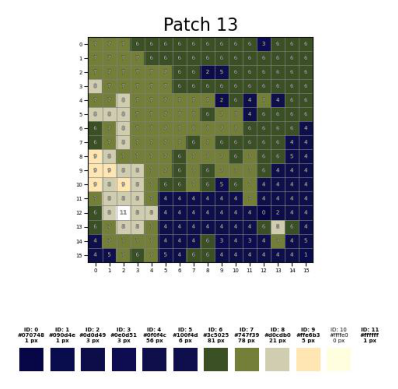

In [217]:
img = mpimg.imread('figures/patches/patch_013.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Success! Now where did that last piece go...

In [225]:
!conda list --export > requirements.txt
with open('requirements.txt', 'r') as file:
    requirements = file.read()

print(requirements)

9756.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: osx-arm64
affine=2.3.0=pyhd3eb1b0_0
anyio=4.6.2=py310hca03da5_0
appnope=0.1.2=py310hca03da5_1001
argon2-cffi=21.3.0=pyhd3eb1b0_0
argon2-cffi-bindings=21.2.0=py310h1a28f6b_0
arrow-cpp=17.0.0=h0b7d223_1
asttokens=2.0.5=pyhd3eb1b0_0
async-lru=2.0.4=py310hca03da5_0
attrs=24.2.0=py310hca03da5_0
aws-c-auth=0.6.19=h80987f9_0
aws-c-cal=0.5.20=h80987f9_0
aws-c-common=0.8.5=h80987f9_0
aws-c-compression=0.2.16=h80987f9_0
aws-c-event-stream=0.2.15=h313beb8_0
aws-c-http=0.6.25=h80987f9_0
aws-c-io=0.13.10=h80987f9_0
aws-c-mqtt=0.7.13=h80987f9_0
aws-c-s3=0.1.51=h80987f9_0
aws-c-sdkutils=0.1.6=h80987f9_0
aws-checksums=0.1.13=h80987f9_0
aws-crt-cpp=0.18.16=h313beb8_0
aws-sdk-cpp=1.11.212=hdd7fb2f_0
babel=2.11.0=py310hca03da5_0
backcall=0.2.0=pypi_0
beautifulsoup4=4.12.3=py310hca03da5_0
blas=1.0=openblas
bleach=6.2.0=py310hca03da5_0
blosc=1.21.3=h313beb8_0
boost-cpp=1.82.0=h48ca7d4_2
bott